In [305]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [306]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22015 entries, 0 to 22014
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22015 non-null  object 
 1   description               22015 non-null  object 
 2   summary                   22014 non-null  object 
 3   installs                  22015 non-null  object 
 4   minInstalls               22015 non-null  float64
 5   score                     22015 non-null  float64
 6   ratings                   22015 non-null  float64
 7   reviews                   22015 non-null  float64
 8   histogram                 22015 non-null  object 
 9   price                     22015 non-null  float64
 10  free                      22015 non-null  int64  
 11  currency                  22015 non-null  object 
 12  sale                      22015 non-null  bool   
 13  offersIAP                 22015 non-null  bool   
 14  inAppP

In [307]:
df_sentiment = pd.read_csv('04-data/sentiment_topics_apps.csv')

In [308]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='appId',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [309]:
df.shape

(22002, 63)

In [310]:
df.columns

Index(['title', 'description', 'summary', 'installs', 'minInstalls', 'score',
       'ratings', 'reviews', 'histogram', 'price', 'free', 'currency', 'sale',
       'offersIAP', 'inAppProductPrice', 'size', 'androidVersion',
       'androidVersionText', 'developer', 'developerId', 'privacyPolicy',
       'developerInternalID', 'genre', 'genreId', 'icon', 'headerImage',
       'screenshots', 'video', 'videoImage', 'contentRating',
       'contentRatingDescription', 'adSupported', 'containsAds', 'released',
       'updated', 'version', 'recentChanges', 'comments', 'editorsChoice',
       'appId', 'url', 'year', 'updated_year', 'description_clean',
       'hist_clean', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5',
       'top_developer', 'current_date', 'days', 'installs_day', 'updated_days',
       'has_video', 'app_ads', 'compatibility', 'updates', 'features', 'bugs',
       'payments', 'use_support'],
      dtype='object')

In [311]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video', 'app_ads', 'compatibility', 'updates', 
        'features', 'bugs','payments', 'use_support']]

y = df['score']

In [312]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [313]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video', 'app_ads', 'compatibility', 'updates', 'features', 'bugs',
       'payments', 'use_support','year']]

In [314]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [315]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [316]:
combo_train_df.columns

Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'top_developer',
       'installs_day', 'updated_days', 'has_video', 'app_ads', 'compatibility',
       'updates', 'features', 'bugs', 'payments', 'use_support', 'year',
       'genre_Action', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music & Audio', 'genre_News & Magazines',
       'genre_Parenting', 'genre_Personalization', 'genre_Photography',
       'genre_Productivity', 'genre_Puzzle', 'genre_Racing',
       'genre_Role

In [317]:
## Add interactions
combo_train_df['use_support_weather'] = combo_train_df['use_support'] * combo_train_df['genre_Weather']
combo_train_df['use_support_shopping'] = combo_train_df['use_support'] * combo_train_df['genre_Shopping']
combo_train_df['use_support_education'] = combo_train_df['use_support'] * combo_train_df['genre_Education']
combo_train_df['use_support_Books'] = combo_train_df['use_support'] * combo_train_df['genre_Books & Reference']
combo_train_df['use_support_comics'] = combo_train_df['use_support'] * combo_train_df['genre_Comics']
combo_train_df['use_support_video'] = combo_train_df['use_support'] * combo_train_df['genre_Video Players & Editors']

combo_train_df['payments_food'] = combo_train_df['payments'] * combo_train_df['genre_Food & Drink']
combo_train_df['payments_medical'] = combo_train_df['payments'] * combo_train_df['genre_Medical']
combo_train_df['payments_shopping'] = combo_train_df['payments'] * combo_train_df['genre_Shopping']
combo_train_df['payments_news'] = combo_train_df['payments'] * combo_train_df['genre_News & Magazines']
combo_train_df['payments_casino'] = combo_train_df['payments'] * combo_train_df['genre_Casino']

combo_train_df['bugs_dating'] = combo_train_df['bugs'] * combo_train_df['genre_Dating']
combo_train_df['bugs_social'] = combo_train_df['bugs'] * combo_train_df['genre_Social']
combo_train_df['bugs_news'] = combo_train_df['bugs'] * combo_train_df['genre_News & Magazines']
combo_train_df['bugs_libraries'] = combo_train_df['bugs'] * combo_train_df['genre_Libraries & Demo']
combo_train_df['bugs_health'] = combo_train_df['bugs'] * combo_train_df['genre_Health & Fitness']
combo_train_df['bugs_casual'] = combo_train_df['bugs'] * combo_train_df['genre_Casual']
combo_train_df['bugs_comics'] = combo_train_df['bugs'] * combo_train_df['genre_Comics']

combo_train_df['features_tools'] = combo_train_df['features'] * combo_train_df['genre_Tools']
combo_train_df['features_news'] = combo_train_df['features'] * combo_train_df['genre_News & Magazines']
combo_train_df['features_music'] = combo_train_df['features'] * combo_train_df['genre_Music & Audio']
combo_train_df['features_card'] = combo_train_df['features'] * combo_train_df['genre_Card']
combo_train_df['features_business'] = combo_train_df['features'] * combo_train_df['genre_Business']
combo_train_df['features_house'] = combo_train_df['features'] * combo_train_df['genre_House & Home']

combo_train_df['updates_library'] = combo_train_df['updates'] * combo_train_df['genre_Libraries & Demo']
combo_train_df['updates_payments'] = combo_train_df['updates'] * combo_train_df['payments']
combo_train_df['updates_shopping'] = combo_train_df['updates'] * combo_train_df['genre_Shopping']
combo_train_df['updates_events'] = combo_train_df['updates'] * combo_train_df['genre_Events']
combo_train_df['updates_art'] = combo_train_df['updates'] * combo_train_df['genre_Art & Design']

combo_train_df['app_ads_social'] = combo_train_df['app_ads'] * combo_train_df['genre_Social']
combo_train_df['app_ads_art'] = combo_train_df['app_ads'] * combo_train_df['genre_Art & Design']
combo_train_df['app_ads_strategy'] = combo_train_df['app_ads'] * combo_train_df['genre_Strategy']
combo_train_df['app_ads_features'] = combo_train_df['app_ads'] * combo_train_df['features']
combo_train_df['app_ads_tools'] = combo_train_df['app_ads'] * combo_train_df['genre_Tools']
combo_train_df['app_ads_entertainment'] = combo_train_df['app_ads'] * combo_train_df['genre_Entertainment']
combo_train_df['app_ads_house'] = combo_train_df['app_ads'] * combo_train_df['genre_House & Home']

combo_train_df['edchoice_Mature'] = combo_train_df['editorsChoice'] * combo_train_df['contentRating_Mature 17+']
combo_train_df['edchoice_teen'] = combo_train_df['editorsChoice'] * combo_train_df['contentRating_Teen']
combo_train_df['edchoice_education'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Education']
combo_train_df['edchoice_house'] = combo_train_df['editorsChoice'] * combo_train_df['genre_House & Home']
combo_train_df['edchoice_art'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Art & Design']
combo_train_df['edchoice_events'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Events']
combo_train_df['edchoice_finance'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Finance']

combo_train_df['ads_adventure'] = combo_train_df['containsAds'] * combo_train_df['genre_Adventure']
combo_train_df['ads_beauty'] = combo_train_df['containsAds'] * combo_train_df['genre_Beauty']
combo_train_df['ads_card'] = combo_train_df['containsAds'] * combo_train_df['genre_Card']
combo_train_df['ads_finance'] = combo_train_df['containsAds'] * combo_train_df['genre_Finance']
combo_train_df['ads_business'] = combo_train_df['containsAds'] * combo_train_df['genre_Business']
combo_train_df['ads_appads'] = combo_train_df['containsAds'] * combo_train_df['app_ads']
combo_train_df['ads_health'] = combo_train_df['containsAds'] * combo_train_df['genre_Health & Fitness']
combo_train_df['ads_roleplay'] = combo_train_df['containsAds'] * combo_train_df['genre_Role Playing']
combo_train_df['ads_maps'] = combo_train_df['containsAds'] * combo_train_df['genre_Maps & Navigation']
combo_train_df['ads_photography'] = combo_train_df['containsAds'] * combo_train_df['genre_Photography']

combo_train_df['compatibility_events'] = combo_train_df['compatibility'] * combo_train_df['genre_Events']
combo_train_df['compatibility_medical'] = combo_train_df['compatibility'] * combo_train_df['genre_Medical']
combo_train_df['compatibility_productivity'] = combo_train_df['compatibility'] * combo_train_df['genre_Productivity']
combo_train_df['compatibility_adventure'] = combo_train_df['compatibility'] * combo_train_df['genre_Adventure']
combo_train_df['compatibility_communication'] = combo_train_df['compatibility'] * combo_train_df['genre_Communication']
combo_train_df['compatibility_news'] = combo_train_df['compatibility'] * combo_train_df['genre_News & Magazines']
combo_train_df['compatibility_features'] = combo_train_df['compatibility'] * combo_train_df['features']

combo_train_df['video_medical'] = combo_train_df['has_video'] * combo_train_df['genre_Medical']
combo_train_df['video_library'] = combo_train_df['has_video'] * combo_train_df['genre_Libraries & Demo']
combo_train_df['video_sport'] = combo_train_df['has_video'] * combo_train_df['genre_Sports']
combo_train_df['video_comics'] = combo_train_df['has_video'] * combo_train_df['genre_Comics']

combo_train_df['topdev_video'] = combo_train_df['top_developer'] * combo_train_df['genre_Video Players & Editors']
combo_train_df['topdev_features'] = combo_train_df['top_developer'] * combo_train_df['features']
combo_train_df['topdev_personalization'] = combo_train_df['top_developer'] * combo_train_df['genre_Personalization']

combo_train_df['free_simulation'] = combo_train_df['free'] * combo_train_df['genre_Simulation']
combo_train_df['free_Photography'] = combo_train_df['free'] * combo_train_df['genre_Photography']

In [318]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

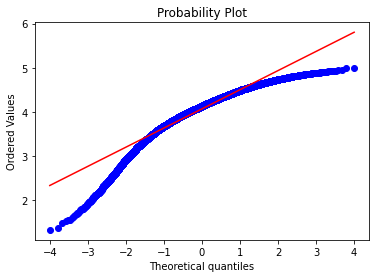

In [319]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 22002
- Mean of distribution of rating : 4.0676669003726715
- Standard deviation: 0.4492370615817515


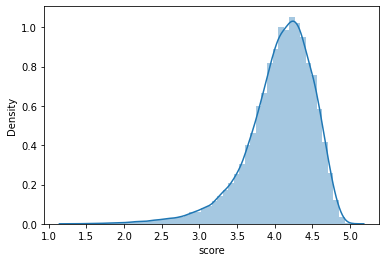

In [320]:
sns.distplot(df['score'])
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))
plt.savefig('test.svg')

## No pipeline

In [321]:
X_train.columns.values.tolist()

['ratings',
 'free',
 'containsAds',
 'editorsChoice',
 'top_developer',
 'installs_day',
 'updated_days',
 'has_video',
 'app_ads',
 'compatibility',
 'updates',
 'features',
 'bugs',
 'payments',
 'use_support',
 'year',
 'genre_Action',
 'genre_Adventure',
 'genre_Arcade',
 'genre_Art & Design',
 'genre_Auto & Vehicles',
 'genre_Beauty',
 'genre_Board',
 'genre_Books & Reference',
 'genre_Business',
 'genre_Card',
 'genre_Casino',
 'genre_Casual',
 'genre_Comics',
 'genre_Communication',
 'genre_Dating',
 'genre_Education',
 'genre_Entertainment',
 'genre_Events',
 'genre_Finance',
 'genre_Food & Drink',
 'genre_Health & Fitness',
 'genre_House & Home',
 'genre_Libraries & Demo',
 'genre_Lifestyle',
 'genre_Maps & Navigation',
 'genre_Medical',
 'genre_Music & Audio',
 'genre_News & Magazines',
 'genre_Parenting',
 'genre_Personalization',
 'genre_Photography',
 'genre_Productivity',
 'genre_Puzzle',
 'genre_Racing',
 'genre_Role Playing',
 'genre_Shopping',
 'genre_Simulation',
 'g

In [322]:
features = ['ratings',
 'free',
 'containsAds',
 'editorsChoice',
 'top_developer',
 'installs_day',
 'updated_days',
 'has_video',
 'app_ads',
 'compatibility',
 'updates',
 'features',
 'bugs',
 'payments',
 'use_support',
 'year',
 'genre_Adventure',
 'genre_Arcade',
 'genre_Art & Design',
 'genre_Auto & Vehicles',
 'genre_Beauty',
 'genre_Board',
 'genre_Books & Reference',
 'genre_Business',
 'genre_Card',
 'genre_Casino',
 'genre_Casual',
 'genre_Comics',
 'genre_Communication',
 'genre_Dating',
 'genre_Education',
 'genre_Entertainment',
 'genre_Events',
 'genre_Finance',
 'genre_Food & Drink',
 'genre_Health & Fitness',
 'genre_House & Home',
 'genre_Libraries & Demo',
 'genre_Lifestyle',
 'genre_Maps & Navigation',
 'genre_Medical',
 'genre_Music & Audio',
 'genre_News & Magazines',
 'genre_Parenting',
 'genre_Personalization',
 'genre_Photography',
 'genre_Productivity',
 'genre_Puzzle',
 'genre_Racing',
 'genre_Role Playing',
 'genre_Shopping',
 'genre_Simulation',
 'genre_Social',
 'genre_Sports',
 'genre_Strategy',
 'genre_Tools',
 'genre_Travel & Local',
 'genre_Trivia',
 'genre_Video Players & Editors',
 'genre_Weather',
 'genre_Word',
 'contentRating_Everyone 10+',
 'contentRating_Mature 17+',
 'contentRating_Teen',
 'use_support_weather',
 'use_support_shopping',
 'use_support_education',
 'use_support_Books',
 'use_support_comics',
 'payments_food',
 'payments_medical',
 'payments_shopping',
 'payments_news',
 'payments_casino',
 'bugs_dating',
 'bugs_social',
 'bugs_news',
 'bugs_libraries',
 'bugs_health',
 'bugs_casual',
 'bugs_comics',
 'features_tools',
 'features_news',
 'features_music',
 'features_card',
 'features_business',
 'features_house',
 'updates_library',
 'updates_payments',
 'updates_shopping',
 'updates_events',
 'updates_art',
 'app_ads_social',
 'app_ads_art',
 'app_ads_strategy',
 'app_ads_features',
 'edchoice_Mature',
 'edchoice_education',
 'edchoice_house',
 'edchoice_art',
 'edchoice_events',
 'edchoice_finance',
 'ads_adventure',
 'ads_beauty',
 'ads_card',
 'ads_finance',
 'ads_appads',
 'ads_health',
 'ads_maps',
 'compatibility_events',
 'compatibility_medical',
 'compatibility_productivity',
 'compatibility_adventure',
 'compatibility_communication',
 'compatibility_news',
 'compatibility_features',
 'video_medical',
 'video_library',
 'topdev_video',
 'topdev_features',
 'free_simulation',
 'ads_roleplay',
 'use_support_video',
 'app_ads_tools',
 'app_ads_entertainment',
 'app_ads_house',
 'edchoice_teen',
 'ads_business',
 'ads_photography',
 'video_sport',
 'video_comics',
 'topdev_personalization',
 'free_Photography']

In [323]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred_a = lr.predict(X_train[features])
print('R^2 of linear regression on train set: {:.2f}'.format(lr.score(X_train[features], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred_a))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred_a))))

R^2 of linear regression on train set: 0.33
MSE of linear regression on train set: 0.13
MAE of linear regression on train set: 0.27


In [324]:
y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [325]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_train[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.00
top_developer : 0.65
installs_day : 0.00
updated_days : -0.00
has_video : 0.05
app_ads : 0.24
compatibility : 0.08
updates : -0.02
features : 1.06
bugs : 0.00
payments : 0.05
use_support : 0.04
year : -0.00
genre_Adventure : 0.02
genre_Arcade : 0.03
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.11
genre_Beauty : 0.13
genre_Board : 0.09
genre_Books & Reference : 0.09
genre_Business : 0.05
genre_Card : 0.07
genre_Casino : 0.08
genre_Casual : -0.02
genre_Comics : 0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.04
genre_Entertainment : -0.01
genre_Events : -0.25
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : -0.02
genre_House & Home : 0.48
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.03
genre_Maps & Navigation : -0.05
genre_Medical : 0.05
genre_Music & Audio : 0.00
genre_News & Magazines : -0.13
genre_Parenting : 0.10
genre_Personal

In [326]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [327]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [328]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,-0.060575,0.090966,-0.073956,-0.002800,0.24832,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.0,0.090966,0.000000,0.00000,0.0,0.0,0.0,-0.0,0.000170,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.059928,0.6588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.025898,2.152475
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,0.151979,0.122676,0.161025,-0.724500,0.30435,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,-0.110108,0.000000,0.0,0.0,0.0,0.0,0.0,0.030730,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.129805,0.000000,0.015924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.940555,2.030287
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,0.000000,0.152960,0.510600,0.189033,0.38298,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.000283,-0.0000,-0.0

In [329]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [330]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.00000,600.00000,600.0,600.000000,600.000000,600.000000,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.0,600.000000,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.0,600.000000,600.0,600.0,600.0,600.0,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.0,600.0,600.000000,600.0,600.0,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000
mean,19898.981667,0.991667,0.778333,0.006667,0.028333,947.550197,357.531667,0.303333,0.240448,0.140887,0.107046,0.159569,0.138299,0.089671,0.358016,2016.033333,0.036667,0.028333,0.028333,0.006667,0.001667,0.001667,0.013333,0.013333,0.008333,0.013333,0.005000,0.045000,0.005000,0.016667,0.013333,0.05500,0.08000,0.0,0.025000,0.003333,0.023333,0.003333,0.0,0.021667,0.005000,0.001667,0.031667,0.005000,0.003333,0.045000,0.038333,0.031667,0

In [331]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
count,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.0,862.00000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.00000,862.000000,862.000000,862.000000,862.000000,862.00000,862.000000,862.000000,862.000000,862.00000,862.0,862.000000,862.000000,862.00000,862.000000,862.00000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.00000,862.000000,862.0,862.000000,862.000000,862.0,862.000000,862.0,862.000000,862.000000,862.000000,862.000000,862.0,862.000000,862.00000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.0,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.0,862.00000,862.0,862.0,862.0,862.0,862.0,862.000000,862.00000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.0,862.000000,862.0,862.0,862.000000,862.0,862.00000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000
mean,21140.029002,0.993039,0.836427,0.006961,0.118329,950.119698,380.585847,0.353828,0.280865,0.149474,0.124337,0.200007,0.121782,0.121001,0.337559,2016.167053,0.053364,0.031323,0.024362,0.009281,0.0,0.00232,0.012761,0.012761,0.011601,0.008121,0.006961,0.061485,0.00232,0.015081,0.003480,0.064965,0.044084,0.00116,0.016241,0.005800,0.019722,0.00232,0.0,0.022042,0.005800,0.00232,0.038283,0.00116,0.003480,0.082367,0.037123,0.026682,0.047564,

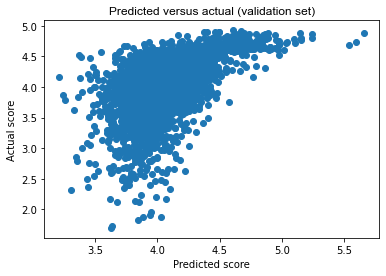

In [332]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

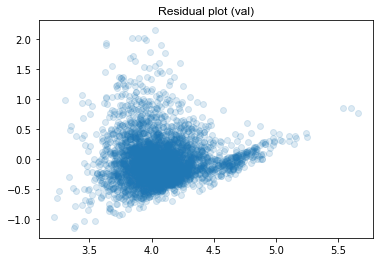

In [333]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing year

In [334]:
features2 = features.copy()
features2.remove('year')

In [335]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [336]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.00
top_developer : 0.65
installs_day : 0.00
updated_days : -0.00
has_video : 0.05
app_ads : 0.24
compatibility : 0.08
updates : -0.02
features : 1.06
bugs : 0.00
payments : 0.05
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.03
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.11
genre_Beauty : 0.13
genre_Board : 0.09
genre_Books & Reference : 0.09
genre_Business : 0.05
genre_Card : 0.07
genre_Casino : 0.08
genre_Casual : -0.02
genre_Comics : 0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.04
genre_Entertainment : -0.01
genre_Events : -0.25
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : -0.02
genre_House & Home : 0.48
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.03
genre_Maps & Navigation : -0.05
genre_Medical : 0.05
genre_Music & Audio : 0.00
genre_News & Magazines : -0.13
genre_Parenting : 0.10
genre_Personalization : 0.1

In [337]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [338]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,-0.060575,0.090966,-0.073956,-0.002800,0.24832,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.0,0.090966,0.000000,0.00000,0.0,0.0,0.0,-0.0,0.000170,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.059928,0.6588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.025579,2.152156
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,0.151979,0.122676,0.161025,-0.724500,0.30435,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,-0.110108,0.000000,0.0,0.0,0.0,0.0,0.0,0.030730,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.129805,0.000000,0.015924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.940559,2.030291
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,0.000000,0.152960,0.510600,0.189033,0.38298,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.000283,-0.0000,-0.0

## Removing installs / day

In [339]:
features3 = features2.copy()
features3.remove('installs_day')

In [340]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [341]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.00
top_developer : 0.65
updated_days : -0.00
has_video : 0.05
app_ads : 0.24
compatibility : 0.08
updates : -0.02
features : 1.06
bugs : 0.00
payments : 0.05
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.03
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.13
genre_Board : 0.09
genre_Books & Reference : 0.09
genre_Business : 0.04
genre_Card : 0.07
genre_Casino : 0.08
genre_Casual : -0.02
genre_Comics : 0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.04
genre_Entertainment : -0.01
genre_Events : -0.24
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : -0.02
genre_House & Home : 0.48
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.03
genre_Maps & Navigation : -0.05
genre_Medical : 0.06
genre_Music & Audio : -0.00
genre_News & Magazines : -0.13
genre_Parenting : 0.10
genre_Personalization : 0.16
genre_Photography

In [342]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [343]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,-0.060575,0.090966,-0.073956,-0.002800,0.24832,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.0,0.090966,0.000000,0.00000,0.0,0.0,0.0,-0.0,0.000170,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.059928,0.6588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.027471,2.154049
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,0.151979,0.122676,0.161025,-0.724500,0.30435,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,-0.110108,0.000000,0.0,0.0,0.0,0.0,0.0,0.030730,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.129805,0.000000,0.015924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.942097,2.031830
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,0.000000,0.152960,0.510600,0.189033,0.38298,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.000283,-0.0000,-0.0

## Removing updated days

In [344]:
#features4 = features3.copy()
#features4.remove('updated_days')

In [345]:
# lr4 = LinearRegression()

# lr4.fit(X_train[features4], y_train)

# y_pred4 = lr4.predict(X_val[features4])
# print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
# print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
# print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

In [346]:
# print('Feature coefficient results: \n')
# for feature, coef in zip(X_val[features4].columns, lr4.coef_):
#         print(feature, ':', f'{coef:.2f}')

In [347]:
# check3 = X_val.copy()
# check3['score'] = y_val
# check3['pred'] = lr3.predict(X_val[features3])
# check3['resid'] = check3['pred'] - check3['score']

In [348]:
# check3.sort_values('resid',ascending =False)

## Removing bugs

In [349]:
features5 = features3.copy()
features5.remove('bugs')

In [350]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [351]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.00
top_developer : 0.65
updated_days : -0.00
has_video : 0.05
app_ads : 0.24
compatibility : 0.08
updates : -0.02
features : 1.06
payments : 0.05
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.03
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.13
genre_Board : 0.09
genre_Books & Reference : 0.09
genre_Business : 0.04
genre_Card : 0.07
genre_Casino : 0.08
genre_Casual : -0.02
genre_Comics : 0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.04
genre_Entertainment : -0.01
genre_Events : -0.24
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : -0.02
genre_House & Home : 0.48
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.03
genre_Maps & Navigation : -0.05
genre_Medical : 0.06
genre_Music & Audio : -0.00
genre_News & Magazines : -0.13
genre_Parenting : 0.10
genre_Personalization : 0.16
genre_Photography : 0.00
genr

In [352]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [353]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,-0.060575,0.090966,-0.073956,-0.002800,0.24832,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.0,0.090966,0.000000,0.00000,0.0,0.0,0.0,-0.0,0.000170,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.059928,0.6588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.027489,2.154067
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,0.151979,0.122676,0.161025,-0.724500,0.30435,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,-0.110108,0.000000,0.0,0.0,0.0,0.0,0.0,0.030730,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.129805,0.000000,0.015924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.942089,2.031821
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,0.000000,0.152960,0.510600,0.189033,0.38298,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.000283,-0.0000,-0.0

## Removing sports

In [381]:
features6 = features5.copy()
features6.remove('genre_Photography')

In [382]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [383]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.00
top_developer : 0.65
updated_days : -0.00
has_video : 0.05
app_ads : 0.24
compatibility : 0.08
updates : -0.02
features : 1.06
payments : 0.05
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.03
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.13
genre_Board : 0.09
genre_Books & Reference : 0.09
genre_Business : 0.04
genre_Card : 0.07
genre_Casino : 0.08
genre_Casual : -0.02
genre_Comics : 0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.04
genre_Entertainment : -0.01
genre_Events : -0.24
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : -0.02
genre_House & Home : 0.48
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.03
genre_Maps & Navigation : -0.05
genre_Medical : 0.06
genre_Music & Audio : -0.00
genre_News & Magazines : -0.13
genre_Parenting : 0.10
genre_Personalization : 0.16
genre_Productivity : 0.07
gen

In [384]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [385]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,-0.060575,0.090966,-0.073956,-0.002800,0.24832,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.0,0.090966,0.000000,0.00000,0.0,0.0,0.0,-0.0,0.000170,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.059928,0.6588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.027489,2.154067
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,0.151979,0.122676,0.161025,-0.724500,0.30435,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,-0.110108,0.000000,0.0,0.0,0.0,0.0,0.0,0.030730,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.129805,0.000000,0.015924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.942089,2.031821
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,0.000000,0.152960,0.510600,0.189033,0.38298,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.000283,-0.0000,-0.0

## Removing Editors choice

In [386]:
features7 = features6.copy()
features7.remove('editorsChoice')

In [387]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [388]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
top_developer : 0.65
updated_days : -0.00
has_video : 0.05
app_ads : 0.24
compatibility : 0.08
updates : -0.02
features : 1.06
payments : 0.05
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.03
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.13
genre_Board : 0.09
genre_Books & Reference : 0.09
genre_Business : 0.04
genre_Card : 0.07
genre_Casino : 0.08
genre_Casual : -0.02
genre_Comics : 0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.04
genre_Entertainment : -0.01
genre_Events : -0.24
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : -0.02
genre_House & Home : 0.48
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.03
genre_Maps & Navigation : -0.05
genre_Medical : 0.06
genre_Music & Audio : -0.00
genre_News & Magazines : -0.13
genre_Parenting : 0.10
genre_Personalization : 0.16
genre_Productivity : 0.07
genre_Puzzle : 0.12
genr

In [389]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [390]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,-0.060575,0.090966,-0.073956,-0.002800,0.24832,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.0,0.090966,0.000000,0.00000,0.0,0.0,0.0,-0.0,0.000170,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.059928,0.6588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.027487,2.154064
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,0.151979,0.122676,0.161025,-0.724500,0.30435,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.0000,-0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,-0.110108,0.000000,0.0,0.0,0.0,0.0,0.0,0.030730,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.129805,0.000000,0.015924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.942078,2.031810
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,0.000000,0.152960,0.510600,0.189033,0.38298,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,-0.0,-0.000283,-0.0000,-0.0

## Removing Music & Audio

In [391]:
features8 = features7.copy()
features8.remove('genre_Music & Audio')

In [392]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [393]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
top_developer : 0.65
updated_days : -0.00
has_video : 0.05
app_ads : 0.24
compatibility : 0.08
updates : -0.02
features : 1.06
payments : 0.05
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.03
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.13
genre_Board : 0.09
genre_Books & Reference : 0.09
genre_Business : 0.04
genre_Card : 0.07
genre_Casino : 0.08
genre_Casual : -0.02
genre_Comics : 0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.04
genre_Entertainment : -0.01
genre_Events : -0.24
genre_Finance : 0.08
genre_Food & Drink : 0.10
genre_Health & Fitness : -0.02
genre_House & Home : 0.48
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.03
genre_Maps & Navigation : -0.05
genre_Medical : 0.06
genre_News & Magazines : -0.13
genre_Parenting : 0.10
genre_Personalization : 0.16
genre_Productivity : 0.07
genre_Puzzle : 0.12
genre_Racing : 0.01
genre_Role P

In [394]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [395]:
pd.set_option('display.max_columns', None)

In [396]:
mid = check8[(check8['resid'] >= -0.1) & (check8['resid'] <= 0.1)]

In [397]:
mid[mid['genre_Tools'] == 1].groupby('year').count()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2011,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2012,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2013,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2014,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2015,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2016,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6

In [398]:
low = check8.sort_values('resid',ascending =False).head(200)

In [399]:
low.head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,-0.060575,0.090966,-0.073956,-0.002800,0.248320,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.00000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.0,0.090966,0.0,0.000000,0.0,0.000000,0.000000,-0.0,0.000170,-0.000000,-0.0,-0.0,0.00000,0.000000,0.0,0.059928,0.658800,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.003942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.027483,2.154060
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,0.151979,0.122676,0.161025,-0.724500,0.304350,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,-0.110108,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.030730,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250500,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.129805,0.0,0.015924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.942088,2.031821
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,0.000000,0.152960,0.510600,0.189033,0.382980,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,

In [400]:
low[low['genre_Lifestyle'] == 1].groupby('year').count()
## photography - 2016
## Tools - 2017
## Entertainment - 2016

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2012,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2013,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2014,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2015,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2016,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2017,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1

In [401]:
low_neg = check8.sort_values('resid',ascending =True).head(150)

In [402]:
low_neg[low_neg['genre_Lifestyle'] == 1].groupby('year').count()
##photgraphy - 2018 
## Entertaiment 2015

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Events,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_events,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_events,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_events,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2014,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2019,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Test

In [403]:
X_test_cont = X_test[['ratings','free','updated_days','containsAds','editorsChoice','top_developer','has_video', 'app_ads', 'compatibility', 'updates', 
        'features', 'bugs','payments', 'use_support']]

In [404]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [405]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [406]:
## Add interactions
combo_test_df['use_support_weather'] = combo_test_df['use_support'] * combo_test_df['genre_Weather']
combo_test_df['use_support_shopping'] = combo_test_df['use_support'] * combo_test_df['genre_Shopping']
combo_test_df['use_support_education'] = combo_test_df['use_support'] * combo_test_df['genre_Education']
combo_test_df['use_support_Books'] = combo_test_df['use_support'] * combo_test_df['genre_Books & Reference']
combo_test_df['use_support_comics'] = combo_test_df['use_support'] * combo_test_df['genre_Comics']
combo_test_df['use_support_video'] = combo_test_df['use_support'] * combo_test_df['genre_Video Players & Editors']

combo_test_df['payments_food'] = combo_test_df['payments'] * combo_test_df['genre_Food & Drink']
combo_test_df['payments_medical'] = combo_test_df['payments'] * combo_test_df['genre_Medical']
combo_test_df['payments_shopping'] = combo_test_df['payments'] * combo_test_df['genre_Shopping']
combo_test_df['payments_news'] = combo_test_df['payments'] * combo_test_df['genre_News & Magazines']
combo_test_df['payments_casino'] = combo_test_df['payments'] * combo_test_df['genre_Casino']

combo_test_df['bugs_dating'] = combo_test_df['bugs'] * combo_test_df['genre_Dating']
combo_test_df['bugs_social'] = combo_test_df['bugs'] * combo_test_df['genre_Social']
combo_test_df['bugs_news'] = combo_test_df['bugs'] * combo_test_df['genre_News & Magazines']
combo_test_df['bugs_libraries'] = combo_test_df['bugs'] * combo_test_df['genre_Libraries & Demo']
combo_test_df['bugs_health'] = combo_test_df['bugs'] * combo_test_df['genre_Health & Fitness']
combo_test_df['bugs_casual'] = combo_test_df['bugs'] * combo_test_df['genre_Casual']
combo_test_df['bugs_comics'] = combo_test_df['bugs'] * combo_test_df['genre_Comics']

combo_test_df['features_tools'] = combo_test_df['features'] * combo_test_df['genre_Tools']
combo_test_df['features_news'] = combo_test_df['features'] * combo_test_df['genre_News & Magazines']
combo_test_df['features_music'] = combo_test_df['features'] * combo_test_df['genre_Music & Audio']
combo_test_df['features_card'] = combo_test_df['features'] * combo_test_df['genre_Card']
combo_test_df['features_business'] = combo_test_df['features'] * combo_test_df['genre_Business']
combo_test_df['features_house'] = combo_test_df['features'] * combo_test_df['genre_House & Home']

combo_test_df['updates_library'] = combo_test_df['updates'] * combo_test_df['genre_Libraries & Demo']
combo_test_df['updates_payments'] = combo_test_df['updates'] * combo_test_df['payments']
combo_test_df['updates_shopping'] = combo_test_df['updates'] * combo_test_df['genre_Shopping']
combo_test_df['updates_events'] = combo_test_df['updates'] * combo_test_df['genre_Events']
combo_test_df['updates_art'] = combo_test_df['updates'] * combo_test_df['genre_Art & Design']

combo_test_df['app_ads_social'] = combo_test_df['app_ads'] * combo_test_df['genre_Social']
combo_test_df['app_ads_art'] = combo_test_df['app_ads'] * combo_test_df['genre_Art & Design']
combo_test_df['app_ads_strategy'] = combo_test_df['app_ads'] * combo_test_df['genre_Strategy']
combo_test_df['app_ads_features'] = combo_test_df['app_ads'] * combo_test_df['features']
combo_test_df['app_ads_tools'] = combo_test_df['app_ads'] * combo_test_df['genre_Tools']
combo_test_df['app_ads_entertainment'] = combo_test_df['app_ads'] * combo_test_df['genre_Entertainment']
combo_test_df['app_ads_house'] = combo_test_df['app_ads'] * combo_test_df['genre_House & Home']

combo_test_df['edchoice_Mature'] = combo_test_df['editorsChoice'] * combo_test_df['contentRating_Mature 17+']
combo_test_df['edchoice_teen'] = combo_test_df['editorsChoice'] * combo_test_df['contentRating_Teen']
combo_test_df['edchoice_education'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Education']
combo_test_df['edchoice_house'] = combo_test_df['editorsChoice'] * combo_test_df['genre_House & Home']
combo_test_df['edchoice_art'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Art & Design']
combo_test_df['edchoice_events'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Events']
combo_test_df['edchoice_finance'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Finance']

combo_test_df['ads_adventure'] = combo_test_df['containsAds'] * combo_test_df['genre_Adventure']
combo_test_df['ads_beauty'] = combo_test_df['containsAds'] * combo_test_df['genre_Beauty']
combo_test_df['ads_card'] = combo_test_df['containsAds'] * combo_test_df['genre_Card']
combo_test_df['ads_finance'] = combo_test_df['containsAds'] * combo_test_df['genre_Finance']
combo_test_df['ads_business'] = combo_test_df['containsAds'] * combo_test_df['genre_Business']
combo_test_df['ads_appads'] = combo_test_df['containsAds'] * combo_test_df['app_ads']
combo_test_df['ads_health'] = combo_test_df['containsAds'] * combo_test_df['genre_Health & Fitness']
combo_test_df['ads_roleplay'] = combo_test_df['containsAds'] * combo_test_df['genre_Role Playing']
combo_test_df['ads_maps'] = combo_test_df['containsAds'] * combo_test_df['genre_Maps & Navigation']
combo_test_df['ads_photography'] = combo_test_df['containsAds'] * combo_test_df['genre_Photography']

combo_test_df['compatibility_events'] = combo_test_df['compatibility'] * combo_test_df['genre_Events']
combo_test_df['compatibility_medical'] = combo_test_df['compatibility'] * combo_test_df['genre_Medical']
combo_test_df['compatibility_productivity'] = combo_test_df['compatibility'] * combo_test_df['genre_Productivity']
combo_test_df['compatibility_adventure'] = combo_test_df['compatibility'] * combo_test_df['genre_Adventure']
combo_test_df['compatibility_communication'] = combo_test_df['compatibility'] * combo_test_df['genre_Communication']
combo_test_df['compatibility_news'] = combo_test_df['compatibility'] * combo_test_df['genre_News & Magazines']
combo_test_df['compatibility_features'] = combo_test_df['compatibility'] * combo_test_df['features']

combo_test_df['video_medical'] = combo_test_df['has_video'] * combo_test_df['genre_Medical']
combo_test_df['video_library'] = combo_test_df['has_video'] * combo_test_df['genre_Libraries & Demo']
combo_test_df['video_sport'] = combo_test_df['has_video'] * combo_test_df['genre_Sports']
combo_test_df['video_comics'] = combo_test_df['has_video'] * combo_test_df['genre_Comics']

combo_test_df['topdev_video'] = combo_test_df['top_developer'] * combo_test_df['genre_Video Players & Editors']
combo_test_df['topdev_features'] = combo_test_df['top_developer'] * combo_test_df['features']
combo_test_df['topdev_personalization'] = combo_test_df['top_developer'] * combo_test_df['genre_Personalization']

combo_test_df['free_simulation'] = combo_test_df['free'] * combo_test_df['genre_Simulation']
combo_test_df['free_Photography'] = combo_test_df['free'] * combo_test_df['genre_Photography']

In [407]:
y_pred_test = lr8.predict(combo_test_df[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(combo_test_df[features8], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.29
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.27


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


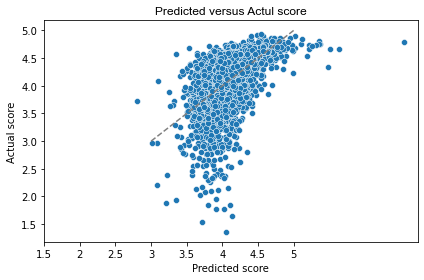

In [408]:
fig, ax = plt.subplots()
sns.scatterplot(y_pred_test,y_test)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(3,5,5), np.linspace(3,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actul score',family='arial',fontsize=12);
#plt.xticks(np.linspace(2,5,7), ['2','2.5','3','3.5','4','4.5','5'])
plt.xticks(np.linspace(1.5,5,8), ['1.5','2','2.5','3','3.5','4','4.5','5'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

In [ ]:
x_values = [0.90,0.55,0.25,0.23,-0.40,-0.16,-0.10]
x_labels = ['Feature sentiment','Top developer','Ads sentiment','Casino','Events','Libraries & Demo','Free']

plt.figure(figsize=[15,5])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.bar(x_labels,x_values)   
plt.title('Strength of coefficient',family='arial',fontsize=16)
plt.tight_layout()
plt.savefig('coefficients_apps.svg');
plt.show;

### Create dataframe for tableau

In [ ]:
df_tableau = df.copy()
df_tableau = df_tableau.drop(columns=['installs','description','summary','histogram','released','currency',
                                     'sale','offersIAP','inAppProductPrice',
                                     'androidVersion','androidVersionText',
                                     'developer','developerId','privacyPolicy',
                                     'developerInternalID','genreId', 'icon', 'headerImage',
                                     'screenshots', 'video', 'videoImage',
                                     'updated', 'version', 'recentChanges', 'comments',
                                     'url','hist_clean','current_date',
                                     'contentRatingDescription','adSupported'])

In [ ]:
#df_tableau.to_csv('dataframe_tableau.csv')